## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import time
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from logger import TBLogger

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [3]:
from matplotlib.image import imread
from extract_patches import *

In [4]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=256)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [5]:
len(images)

1564

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

In [7]:
def show_img_grid(images, grid_shape = (4, 4)):
    fig, img_plots = plt.subplots(*grid_shape, figsize=(8, 8), gridspec_kw = {'wspace':0.05, 'hspace':0.05})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_shape[0]):
        for j in range(0, grid_shape[1]):
            img_plt = img_plots[i, j]

            img = images[i * grid_shape[1] + j]
            img_plt.imshow(np.squeeze(img), cmap="afmhot")
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


In [8]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

In [9]:
tensor_images.size()

torch.Size([1564, 1, 256, 256])

In [10]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
TINY = 1e-15
EMBEDDING_SIZE = 1500
conv_emb_size = 25 * 8 * 8

## Load saved Model

In [12]:
class ConvAAE():
    class Encoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Encoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(),

                nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(),

                nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(),

                nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(),

                nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(),

                Flatten(),
                
                # we need this layer to force the gaussian form of the embeddings
                nn.Linear(conv_emb_size, EMBEDDING_SIZE),
                
                # no activation here!
            )

        def forward(self, input_data):
            # generate embeddings for our images
            embeddings = self.encoder(input_data)

            return embeddings

        
    class Decoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Decoder, self).__init__()
            self.decoder = nn.Sequential(
                nn.Linear(EMBEDDING_SIZE, conv_emb_size),
                
                Unflatten(C=25, H=8, W=8),

                nn.ConvTranspose2d(25, 20, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),

                nn.ConvTranspose2d(20, 15, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),

                nn.ConvTranspose2d(15, 10, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),

                nn.ConvTranspose2d(10, 5, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),

                nn.ConvTranspose2d(5, image_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
            )

        def forward(self, input_embeddings):
            # reconstruct images using decoder
            decoded_data = self.decoder(input_embeddings)

            return decoded_data


    class Discriminator(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Discriminator, self).__init__()

            self.discriminator = nn.Sequential(
                # linear layer with 150 elements
                nn.Linear(EMBEDDING_SIZE, 150),
                nn.LeakyReLU(),

                # linear layer with 1 element
                nn.Linear(150, 1),

                nn.Sigmoid()
            )

        def forward(self, input_embeddings):
            # process embeddings and guess if it's real or fake
            discriminator_output = self.discriminator(input_embeddings)

            return discriminator_output

print('    ENCODER')
summary(ConvAAE.Encoder().to(device), (1, 256, 256))

print('\n\n    DECODER')
summary(ConvAAE.Decoder().to(device), (1, EMBEDDING_SIZE))

print('\n\n    DISCRIMINATOR')
summary(ConvAAE.Discriminator().to(device), (1, EMBEDDING_SIZE))

    ENCODER
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
           Linear-12                 [-1, 1500]       2,401,500
Total params: 2,426,700
Trainable params: 2,426,700
Non-trainable params: 0
---------------

In [13]:
learning_rate = 1e-5


def reset_model():
    global get_reconstruction_loss, get_discriminator_loss, encoder_net, decoder_net, discrim_net
    global decoder_optimizer, encoder_optimizer, encoder_generator_optimizer, discriminator_optimizer

    get_reconstruction_loss = nn.MSELoss()
    get_discriminator_loss = nn.BCEWithLogitsLoss()

    # creating sub-models
    encoder_net = ConvAAE.Encoder().to(device)
    decoder_net = ConvAAE.Decoder().to(device)
    discrim_net = ConvAAE.Discriminator().to(device)

    # optimizes decoder
    decoder_optimizer = torch.optim.Adam(decoder_net.parameters(), weight_decay=1e-6, lr=learning_rate)

    # optimizes encoder/generator
    encoder_optimizer = torch.optim.Adam(encoder_net.parameters(), weight_decay=1e-6, lr=learning_rate)

    # optimizes encoder/generator
    encoder_generator_optimizer = torch.optim.Adam(encoder_net.parameters(), 
        weight_decay=1e-6, lr=learning_rate / 50)

    # optimizes discriminator
    discriminator_optimizer = torch.optim.Adam(discrim_net.parameters(), 
        weight_decay=1e-6, lr=learning_rate / 50)


reset_model()

In [51]:
models_folder = './logs/temp/caae_G&D 20-39-15/models/'
target_epoch = 2370

reset_model()

encoder_net.load_state_dict(torch.load(models_folder + f'encoder_net_e_{target_epoch}.pth'))
decoder_net.load_state_dict(torch.load(models_folder + f'decoder_net_e_{target_epoch}.pth'))
discrim_net.load_state_dict(torch.load(models_folder + f'discrim_net_e_{target_epoch}.pth'))

_ = encoder_net.eval(), decoder_net.eval(), discrim_net.eval()

### Test

In [52]:
def predict(images):
    test_data = images.to(device)

    # forward
    embeddings = encoder_net(test_data)
    test_output = decoder_net(embeddings)
    
    return embeddings.data.cpu().numpy(), test_output.data.cpu().numpy()


def predict_and_print(images):
    embeddings, predicted_images = predict(images)

    show_img_grid(predicted_images)


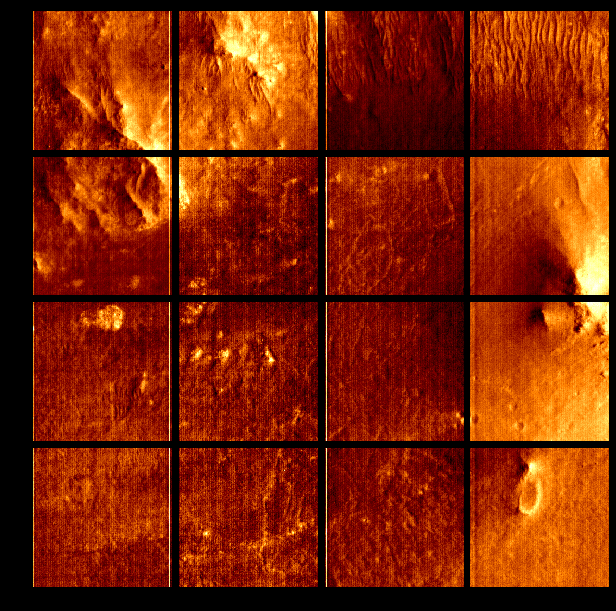

In [53]:
show_img_grid(tensor_images[16:32])

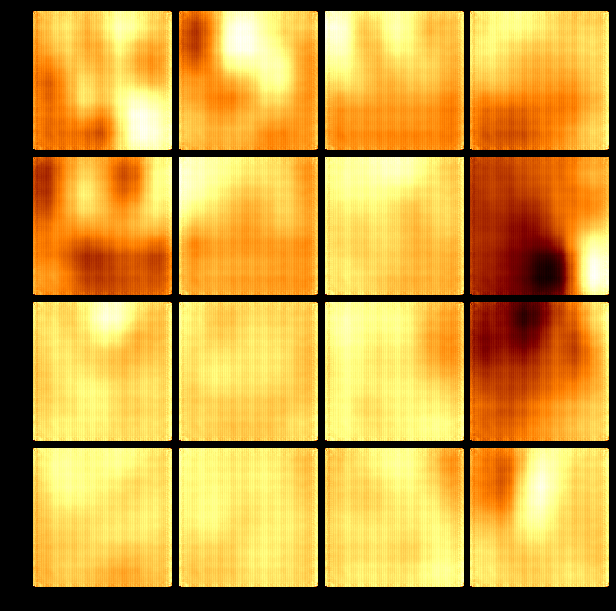

In [54]:
predict_and_print(tensor_images[16:32])

In [55]:
embeddings, _ = predict(tensor_images[0:1])
np.squeeze(embeddings).shape

(1500,)

In [56]:
import seaborn as sns

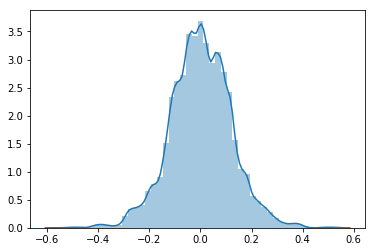

In [57]:
embeddings, _ = predict(tensor_images[0:200])

sns.distplot(np.concatenate(embeddings))

In [24]:
from itertools import cycle
from os import listdir
from os.path import isfile, join

In [25]:
data_path = './data'
files_per_epoch = 5

# get all red files
red_img_files = [f for f in listdir(data_path)
                 if isfile(join(data_path, f)) and 'RED' in f]

In [48]:
for img_name in red_img_files:
    sample_img = np.asarray(extract_img(f'data/{img_name}'))

    if sample_img.shape[0] == 1000:
        print('skipping corrupted image')
        continue
    
    sample_img = sample_img[..., np.newaxis]

    patches = extract_patches(sample_img, patch_size=256)
    
    images, ids = get_patches_ids(patches, img_name)
    
    plt.imsave('./imgs_test/' + ids[0] + '.png', np.squeeze(images[0]))
    
    print(sample_img.shape)

(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(75000, 512, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(80000, 1024, 1)
(60000, 1024, 1)
(60000, 1024, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(50000, 1024, 1)
(30000, 512, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(60000, 1024, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(50000, 256, 1)
(50000, 256, 1)
(50000, 1024, 1)
(60000, 1024, 1)
(40000, 512, 1)
(40000, 512, 1)
(40000, 512, 1)
(30000, 512, 1)
(30000, 512, 1)
(40000, 512, 1)
(40000, 512, 1)
(45000, 1024, 1)
(40000, 512, 1)
(40000, 512, 1)
(40000, 1024, 1)
(50000, 1024, 1)
(45000, 512, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(35000, 512, 1)
(35000, 512, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(45000, 1024, 1)
(45000, 1024, 1)
(35000, 512, 1)
(35000, 512, 1)
(60000, 1024, 1)
(30000, 256, 1)
(40000, 1024, 1)
(70000, 1024, 1)
(100000, 1024, 